Mario Pasquato - MSCA-IF fellow, Université de Montréal - mario.pasquato@gmail.com

# Clustering or unsupervised classification

## Goals of this unit

[Finding groups in data](https://onlinelibrary.wiley.com/doi/book/10.1002/9780470316801) can be very rewarding. A group of data points that behave similarly to each other is likely to represent a class of objects with similar physical properties. Devising ways to group new astronomical objects into hopefully meaningful classes (unsupervised classification) and/or a large number of newly observed objects to previously defined classes (supervised classification) is a large part of observational astronomy.

![secchi](Star_spectra_by_Secchi.jpg)

Let's import the usual stuff, and read the dataset. Now I am reading in two more columns, which are the effective temperature $T_{eff}$, called TEFF in the column header, and the log surface gravity $\log g$, called LOGG.
I am doing this because I want to use the ($T_{eff}$, $\log g$) plane to test out some clustering algorithms before we apply them to the high dimensional space of element abundances.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

oc_star_chemical = pd.read_csv('OC_UVES_iDR5.csv', low_memory = False)
element_names = np.array(['HE1', 'LI1', 'C1', 'C2', 'C3', 'N2', 'N3', 'O1', 'O2', 'NE1', \
                 'NE2', 'NA1', 'MG1', 'MG2', 'AL1', 'AL2', 'AL3', 'SI1', 'SI2', \
                 'SI3', 'SI4', 'S1', 'S2', 'S3', 'CA1', 'CA2', 'SC1', 'SC2', 'TI1',\
                 'TI2', 'V1', 'V2', 'CR1', 'CR2', 'MN1', 'FE1', 'FE2', 'FE3', 'CO1',\
                 'NI1', 'CU1', 'ZN1', 'SR1', 'Y1', 'Y2', 'ZR1', 'ZR2', 'NB1', 'MO1',\
                 'RU1', 'BA2', 'LA2', 'CE2', 'PR2', 'ND2', 'SM2', 'EU2', 'GD2', 'DY2', 'GES_FLD', 'TEFF', 'LOGG']) #<-what's this?

nas_by_column = np.array([oc_star_chemical[element].isna().sum() for element in element_names])

decent_elements = nas_by_column/oc_star_chemical.shape[0] < 0.3
decent_element_names = element_names[decent_elements]
clean_oc_star_chemical = oc_star_chemical[decent_element_names].dropna(axis = 0, how = 'any')

In [2]:
plt.figure(figsize=(10,10))
plt.scatter(np.log10(clean_oc_star_chemical['TEFF']), clean_oc_star_chemical['LOGG'], s = 10.0, color = "#1240A1")
plt.ylabel(r'$\log{g}$ (m/s$^2$)', fontsize=20) #this is how you add latex labels, annotations, etc...
plt.xlabel(r'$\log{T_{\mathrm{eff}}}$ (K)', fontsize=20)
plt.show()

For reference, the Sun's surface gravity is about 275 $m/s^2$, and its effective temperature is $\approx 5770$ Kelvin.

![Log g VS T eff](loggTeff.png)

This is the plot from the thesis of Gianluca Daniel, a brilliant student of mine at Padua University. He graduated in $2020$, using this dataset. Since this is astronomy the axes are reversed. The initial selection of stars to be included in the study is also different than ours. You can see some theoretical curves superimposed here, because we know enough stellar physics to be able to simulate the evolution of stars in this plane (under some assumptions, of course). This allows us to understand the approximate age of a star. Find the typo in the legend.

## Density-based clustering, i.e. DBSCAN, again
Let's try DBSCAN on this plane to see if we can catch the two obvious groups (are they obvious to you though? don't trust the people that abuse the word _obvious_). But first scale the data.

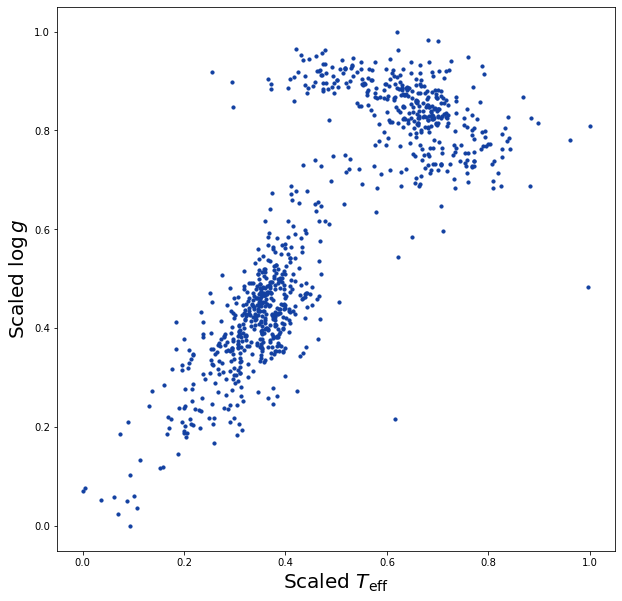

In [3]:
from sklearn.preprocessing import MinMaxScaler
rs = MinMaxScaler()
loggteff = clean_oc_star_chemical[["LOGG", "TEFF"]].copy()
loggteff["TEFF"] = np.log10(loggteff["TEFF"])
loggteff = pd.DataFrame(rs.fit_transform(loggteff),columns=["LOGG", "TEFF"])
plt.figure(figsize=(10,10))
plt.scatter(loggteff['TEFF'], loggteff['LOGG'], s = 10.0, color = "#1240A1")
plt.ylabel(r'Scaled $\log{g}$', fontsize=20) #this is how you add latex labels, annotations, etc...
plt.xlabel(r'Scaled $T_{\mathrm{eff}}$', fontsize=20)
plt.show()

We can visualize the density of points in this space with an [hexbin plot](https://medium.com/@mattheweparker/visualizing-data-with-hexbins-in-python-39823f89525e), because [hexagons](https://www.youtube.com/watch?v=thOifuHs6eY). This is essentially a 2D histogram with hexagonal bins.

In [4]:
plt.figure(figsize=(10,10))
plt.hexbin(loggteff['TEFF'], loggteff['LOGG'], cmap='viridis', gridsize=20)
plt.colorbar()
plt.ylabel(r'Scaled $\log{g}$', fontsize=20)
plt.xlabel(r'Scaled $T_{\mathrm{eff}}$', fontsize=20)
plt.show()

On to clustering... We will be using [sklearn.cluster](https://scikit-learn.org/stable/modules/clustering.html).

In [5]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.05, min_samples=6, metric='euclidean').fit(loggteff)

labels_dbscan = db.labels_

plt.figure(figsize=(10,10))
plt.scatter(loggteff['TEFF'], loggteff['LOGG'], s = 10.0, c = labels_dbscan)
plt.ylabel(r'Scaled $\log{g}$', fontsize=20)
plt.xlabel(r'Scaled $T_{\mathrm{eff}}$', fontsize=20)
plt.show()

DBSCAN is a density-based approach to clustering, and it shows. Look at what happens if we overlap the groups found by DBSCAN and the hexbin plot above.

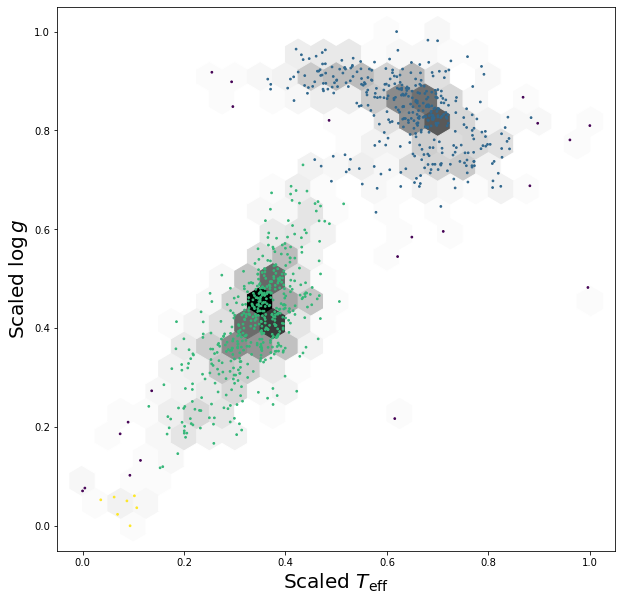

In [6]:
plt.figure(figsize=(10,10))
plt.hexbin(loggteff['TEFF'], loggteff['LOGG'], cmap='gray_r', gridsize=20) #append _r to reverse color map
plt.scatter(loggteff['TEFF'], loggteff['LOGG'], s = 3.0, c = labels_dbscan)
plt.ylabel(r'Scaled $\log{g}$', fontsize=20)
plt.xlabel(r'Scaled $T_{\mathrm{eff}}$', fontsize=20)
plt.show()

The bridge connecting the green and the blue group is broken off right where density is the smallest.

Note that with DBSCAN we get to choose the number of groups only indirectly, by tweaking $k$ and $\epsilon$.
In this case theory tells us that there are two groups, giant stars (the green ones) and main sequence stars (the blue ones).

But DBSCAN came up with three groups (see the yellow one in the bottom left corner). Moreover, some points are labeled as _noise points_, which means we have one more group.

#### What if we wanted to partition a data set into a given number of clusters, no matter what?
There may be non-scientific reasons for doing this, for example data compression. Or I may have a strong prior belief as to what the number of clusters really should be, because for instance of theoretical expectations.

## Partitioning methods

Given a desired number of clusters $k$, we want to assign our points $x_i$ ($i = 1, ..., n$) to at least one and to only one cluster $S_j$ ($j = 1, ..., k$). Hence the name partitioning method.

## k-means
The simplest, most time tested partitioning method is [k-means](https://en.wikipedia.org/wiki/K-means_clustering).
It works with points that live in a vector space (you need to be able to sum them with each other at the very least, and you need a norm), as is the case for our points.
Its objective (the actual k-means algorithm approximates this goal, but it is not guaranteed to achieve it) is to come up with a partition that minimizes
\begin{equation}
\sum_{j = 1}^k \sum_{x_i \in S_j} ||x_i - \mu_j||^2
\end{equation}
where $d$ is a distance, typically Euclidean, and
\begin{equation}
\mu_j = \frac{1}{|S_j|} \sum_{x_i \in S_j} x_i
\end{equation}

What does this mean? You want the points to be as close as possible to the mean of the group they have been assigned to. This is a reasonable thing to require for a cluster, but we will see that the result is not always desirable.

In [7]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(loggteff)
labels_kmeans = km.labels_

plt.figure(figsize=(10,10))
plt.hexbin(loggteff['TEFF'], loggteff['LOGG'], cmap='gray_r', gridsize=20)
plt.scatter(loggteff['TEFF'], loggteff['LOGG'], s = 3.0, c = labels_kmeans)
plt.ylabel(r'Scaled $\log{g}$', fontsize=20) 
plt.xlabel(r'Scaled $T_{\mathrm{eff}}$', fontsize=20)
plt.show()

This is what happens if we use k-means to partition our dataset in two. You see that unlike DBSCAN the border between the two clusters is no longer corresponding to a minimum density region. This is not very visible here, but let's see what happens if we ask for 3 clusters.

In [62]:
km = KMeans(n_clusters=2)
km.fit(loggteff)
labels_kmeans = km.labels_

plt.figure(figsize=(10,10))
plt.hexbin(loggteff['TEFF'], loggteff['LOGG'], cmap='gray_r', gridsize=20)
plt.scatter(loggteff['TEFF'], loggteff['LOGG'], s = 3.0, c = labels_kmeans, cmap='viridis_r')
plt.ylabel(r'Scaled $\log{g}$', fontsize=20) 
plt.xlabel(r'Scaled $T_{\mathrm{eff}}$', fontsize=20)
plt.show()

The purple and the blue/green groups are separated by a line that cuts through a high density region. This is because k-means cares only about distances, not density.

## Intermezzo: comparing partitions

What if we have two different partitions of a data set and we want to compare them? One could have been obtained with a clustering method and another could be expected from theory; or we could be interested in comparing different clustering methods.

Directly comparing labels won't cut it, especially if the number of clusters is different. For example:

In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix([0,0,2,2,1,1,3,3],[0,0,1,1,2,2,3,3])

array([[2, 0, 0, 0],
       [0, 0, 2, 0],
       [0, 2, 0, 0],
       [0, 0, 0, 2]])

If the labels $0$, $1$, $2$ and $3$ have the same meaning then I may conclude that the two assignment to clusters disagree (half of the points are off diagonal). But labels are arbitrary, they are just conventional names for a cluster that was found by the algorithm. So if I swap $1$ and $2$ in the first labels I get

In [10]:
confusion_matrix([0,0,1,1,2,2,3,3],[0,0,1,1,2,2,3,3])

array([[2, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 2, 0],
       [0, 0, 0, 2]])

Perfect agreement! In general the number of off-diagonal items depends on how I label my clusters. This boils down to a decision of which cluster is which. We could for example choose the labeling that minimizes the fraction of off-diagonal instances.

**Or we could choose a different strategy altogether.**

## Rand Index

The idea behind the [Rand index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html#sklearn.metrics.rand_score) is to compare partitions $P$ and $Q$ by considering all couples of points in our dataset.

So we count the unordered couples of points that belong together (in the same cluster, it does not matter which one or how it is labeled) according to partition $P$ and to partition $Q$. We call this number $a$.

Then we consider the couples that were in different subsets in $P$ and are still in different subsets in $Q$, and call their number $b$.

The total number of couples is $C = n(n-1)/2$.

We define

\begin{equation}
R = \frac{a+b}{C}
\end{equation}


A vivid example is what happens to cities (or pixels) when state entities change over time. Compare Europe in 1900 and in 1960:

![1900](1900.png)
![1960](1960.png)

Krakow and Warsaw are together in 1960 but were separated in 1900. Berlin and Munich were together but got separated.
If you take an equal-area map and use pixels instead of cities you could use the Rand index to measure the speed of history. You could take the data from [here](http://geacron.com).

In [63]:
from sklearn.metrics import rand_score

rand_score(labels_kmeans, labels_dbscan)

0.9481763066542805

So clustering with DBSCAN and with k-means yields similar results, according to the Rand index.

## On our main dataset

Let's see how k-means fares on our main data-set, the one of chemical abundances. We will compare the clusters found by k-means to the clusters that we expect to exist based on the fact that the telescope was pointed towards different objects. Rememeber GES_FLD?

In [68]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler(quantile_range=(20.0, 80.0))
robust_scaled_oc_star_chemical = rs.fit_transform(clean_oc_star_chemical.drop(["GES_FLD", "TEFF", "LOGG"], axis=1))
robust_scaled_oc_star_chemical = pd.DataFrame(robust_scaled_oc_star_chemical)
old_column_names = clean_oc_star_chemical.columns
robust_scaled_oc_star_chemical.columns = old_column_names[:-3]

#len(clean_oc_star_chemical["GES_FLD"].unique())

km = KMeans(n_clusters=20) #this is cheating though...
km.fit(robust_scaled_oc_star_chemical)
print(km.labels_)

rand_score(km.labels_, clean_oc_star_chemical["GES_FLD"])

[14  8  8  4  8  4  8  8 17 17 17 17 17 16  0 14  8  8  2  8  8  4  8  8
  8  7  8  8  8  8 16 14  8 14  8  8  8  7  2 10  4 13 14  0 14  9 15  3
 19 14  9  0  7  1 19  8  8 11 11 11  9 18 11  3 11  1 11 11 11 11 11  9
  9  6 11 18 11 11  1 11 11 11 11 11 11 11 11 18 11 11 11 11  1  1 11 11
 11 11 11  3 11  3 11 11 11 11 11 11 11 11 11  9 11  1 11 11 11 11 11  9
 11 13  3 11 11 11 11  4 11 11  1 18 11  6  0 14 19  8  0  4  5  8  8  8
  8 16  8 19 16  0  5  8  8  8  8 17  8  7  8  8 18  9  1  5  4  1 16  7
  8  4  8  4  5  0  2 14  4  8  0  8  8  4  7 16 14  0  5  7 19  8  7  8
  5  4  1  7 14 14 18  7  7  0  5  5  5  5  4  0  5  5  5  5  5  0 14  5
  2  5  2  5  4  5  4 14  4  4 18  4  4  4  8 11  0  0  4  0  0  8  0  5
  1  8  4  7  4  2  0  0  0  0  5  2  0  0  0  0  5  5 17  2  0 14 14  0
 11  2  3  2 14 14 16  2 16  2  2 14  2  2  2  4  2  2  2  2  4 16  2  2
  2  2  2  2 16  2  2  2  2  2  2  2  2  0  2  2  2  2  2  2  2  2  2 16
  2 12 16  4  9  8  4  8  4  8  8  6  7  8 18 19 14

0.9029775583044052

Why did I say that we are cheating? Because the point of the exercise is to recover groups of stars from the field without knowing in advance how many there are. When we will be working with new real data from a part of the galaxy that has no obviously surviving clusters we will not know how many clusters were there to begin with. Here we are testing out unsupervised classifier against a known classification, but we should not use any information from that known classification to tweak the classifier. Otherwise we will believe that it is performing better than it really is!

So how do I know how many clusters to look for without cheating? There are various metrics. One that I like is the

## Silhouette width
What if I wanted to see how 'well clustered' is each point? I would like to build a measure of how firmly a given point is assigned to a cluster. This is most suitable for distance based methods. For any given point $x$ who is not alone in a cluster and for any cluster $S$ we can calculate 

\begin{equation}
d_S = \frac{1}{|S - \{x\}|} \sum_{y \in S, y \neq x} d(x,y) 
\end{equation}

Now if there are two or more clusters we can consider the cluster $S$, to which point $x$ has been assigned and the cluster $R \neq S$ for which $d_R$ is the smallest. We define the silhouette width as

\begin{equation}
s(x) = \frac{d_R - d_S}{\max(d_R, d_S)} 
\end{equation}

We can think of $R$ as the neighboring cluster, or the one to which $x$ would have been assigned if not to $S$.
Note that if the clustering is good according to our intuition, we would expect $s(x)$ to be positive for most points, or even close to $1$. 

[]

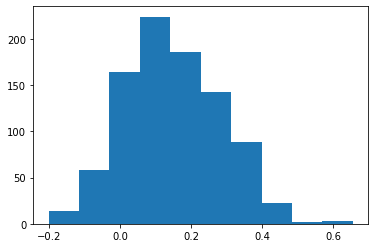

In [78]:
from sklearn.metrics import silhouette_samples
km = KMeans(n_clusters=40)
km.fit(robust_scaled_oc_star_chemical)
labels_kmeans = km.labels_

silhouettes_by_point = silhouette_samples(robust_scaled_oc_star_chemical, labels_kmeans)
plt.hist(silhouettes_by_point)
plt.plot()

#plt.figure(figsize=(10,10))
#plt.hexbin(loggteff['TEFF'], loggteff['LOGG'], cmap='gray_r', gridsize=20)
#plt.scatter(loggteff['TEFF'], loggteff['LOGG'], s = 3.0, c = silhouettes_by_point, cmap='viridis')
#plt.colorbar()
#plt.ylabel(r'Scaled $\log{g}$', fontsize=20) 
#plt.xlabel(r'Scaled $T_{\mathrm{eff}}$', fontsize=20)
#plt.show()

We can then use $s(x)$ not only as a measure of how firmly clustered each instance is, but also of how good a given cluster is (by taking its mean over said cluster) and of how good the general clustering structure is for the whole dataset.

This can be used as a guide in selecting the number of clusters.

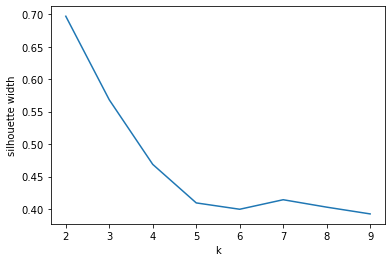

In [27]:
def clustering_quality(data_frame, k):
    km = KMeans(n_clusters=k)
    km.fit(data_frame)
    labels_kmeans = km.labels_
    silhouettes_by_point = silhouette_samples(data_frame, labels_kmeans)
    return silhouettes_by_point.mean()

cq = [clustering_quality(loggteff, k) for k in 2+np.arange(8)]
plt.plot(2+np.arange(8), cq)
plt.xlabel("k")
plt.ylabel("silhouette width")
plt.show()

So it looks like that the sensible number of clusters for our data (in the LOGG, TEFF plane) is indeed 2.
What about chemical abundance space?

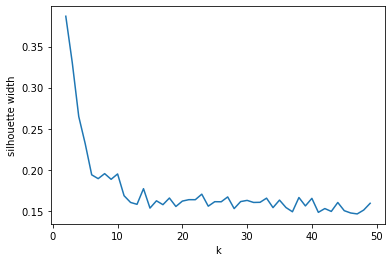

In [29]:
cq = [clustering_quality(robust_scaled_oc_star_chemical, k) for k in 2+np.arange(48)]
plt.plot(2+np.arange(48), cq)
plt.xlabel("k")
plt.ylabel("silhouette width")
plt.show()

This does not look very encouraging: two clusters are better than any other number. But maybe the mean silhouette width is not very informative. Let's have a look at at the median and the other quartiles.

In [56]:
def clustering_quality_allstats(data_frame, k):
    km = KMeans(n_clusters=k)
    km.fit(data_frame)
    labels_kmeans = km.labels_
    silhouettes_by_point = silhouette_samples(data_frame, labels_kmeans)
    return np.quantile(silhouettes_by_point, [0.25, 0.5, 0.75])

cq = [clustering_quality_allstats(robust_scaled_oc_star_chemical, k) for k in 2+np.arange(48)]

silhouettes_q1 = np.array(cq)[:,0]
silhouettes_median = np.array(cq)[:,1]
silhouettes_q3 = np.array(cq)[:,2]

plt.plot(2+np.arange(48), silhouettes_q1)
plt.plot(2+np.arange(48), silhouettes_median)
plt.plot(2+np.arange(48), silhouettes_q3)
plt.xlabel("k")
plt.ylabel("silhouette width")
plt.show()

Same situation. At this point I am wondering if silhouette width would help me choose the right number of clusters in a situation where it is really clear cut.

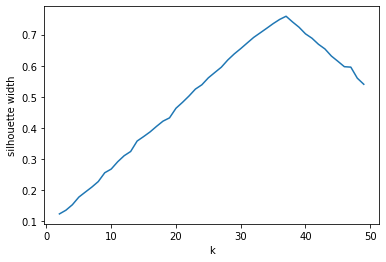

In [74]:
from sklearn.datasets import make_blobs

#X, y = make_blobs(n_samples=robust_scaled_oc_star_chemical.shape[0], n_features=18, centers = 37)

cq = [clustering_quality(X, k) for k in 2+np.arange(48)]
plt.plot(2+np.arange(48), cq)
plt.xlabel("k")
plt.ylabel("silhouette width")
plt.show()

Aha.

Looks like our naive attempt at [chemical tagging](https://indico.fnal.gov/event/13478/images/556-Yuan-Sen_Ting_CEMP.pdf) didn't work for now. People say it [can't be done](https://arxiv.org/abs/2108.13431). Which of course means we should try harder...